# Transformer Encoders Tutorial

In this tutorial you will explore the **self-attention mechanism**, the **word-piece tokenization**, and understand the differences between a Transformer **cross-encoder** and a Transformer **dual-encoder**. 

## Install the libraries

In [1]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1625, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1625 (delta 226), reused 220 (delta 208), pack-reused 1304
Receiving objects: 100% (1625/1625), 198.36 MiB | 1.12 MiB/s, done.
Resolving deltas: 100% (1068/1068), done.


## Imports and definitions

In [41]:
from bertviz import model_view, head_view
import transformers
from transformers import *

import numpy as np
import pprint

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch

In [3]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
    
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)


# Select your model

There are many models available at HuggingFace models repository. These are stable models that were made available by researchers and the industry.

https://huggingface.co/models

The example below is the most popular Transformer model, BERT, a cross-encoder trained on the Next Sentence Prediction task and Masked Language Model task:

In [4]:
model_path = 'bert-base-uncased'
CLS_token = "[CLS]"
SEP_token = "[SEP]"

In [42]:
transformers.logging.set_verbosity_warning()

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

# Input Tokenization

See here for details: https://huggingface.co/docs/transformers/tokenizer_summary

In [7]:
sentence_a = "word word word word word"




sentence_a = "Is throat cancer treatable nowadays?"
sentence_b = "Tell me about lung cancer."
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
pprint.pprint(inputs)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  101,  2003,  3759,  4456,  7438,  3085, 13367,  1029,   102,  2425,
          2033,  2055, 11192,  4456,  1012,   102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])}


In [8]:
print(tokenizer.decode(inputs["input_ids"][0].tolist()))

[CLS] is throat cancer treatable nowadays? [SEP] tell me about lung cancer. [SEP]


In [9]:
input_ids = inputs['input_ids']
pprint.pprint(input_ids[0].tolist())

[101,
 2003,
 3759,
 4456,
 7438,
 3085,
 13367,
 1029,
 102,
 2425,
 2033,
 2055,
 11192,
 4456,
 1012,
 102]


In [10]:
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
pprint.pprint(tokens)

['[CLS]',
 'is',
 'throat',
 'cancer',
 'treat',
 '##able',
 'nowadays',
 '?',
 '[SEP]',
 'tell',
 'me',
 'about',
 'lung',
 'cancer',
 '.',
 '[SEP]']


# Model inference output

In [11]:
with torch.no_grad():
    outputs = model(**inputs)

In [12]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

## Output layer embeddings

In [13]:
# the last layer is the output embedding layer
output_embeddings = outputs['last_hidden_state']

In [14]:
token_throat = 2
token_cancer = 3
# out[0][token]
throat_output_embedding = output_embeddings[0][token_throat]
throat_output_embedding.shape

torch.Size([768])

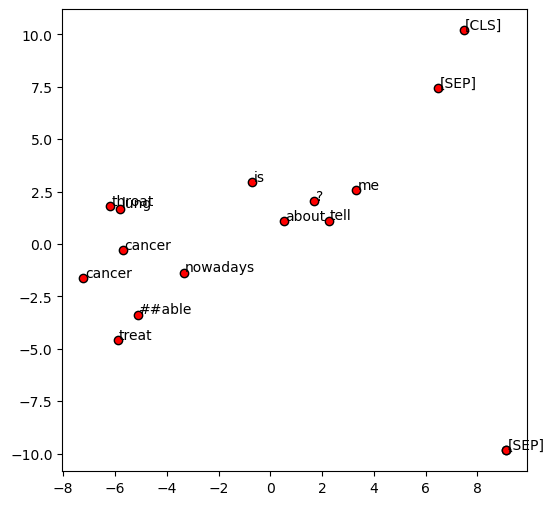

In [15]:
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

    return

display_scatterplot(output_embeddings[0].detach().numpy(), tokens)

## Hidden layer embeddings

In [16]:
hidden_states = outputs['hidden_states']

In [17]:
#This is the output token embedding for the word cancer
layer = 0
throat_input_embedding = hidden_states[layer][0][token_throat]
throat_input_embedding.shape

torch.Size([768])

## Self-attention matrices

In [21]:
attention = outputs['attentions']
# The format of the attention tensor is:
# attention[layer][0][head][token1][token2]
layer = 3
head = 3

In [22]:
# this will given the attention from one token vs the other token
attention[layer][0][head][token_throat][token_cancer]

tensor(0.0559)

In [23]:
attention[layer][0][head].size()

torch.Size([16, 16])

In [24]:
# There's a softmax, so, the sum should be 1 
attention[layer][0][head][token_throat].sum()

tensor(1.0000)

In [25]:
attention[layer][0][head][token_cancer].sum()

tensor(1.)

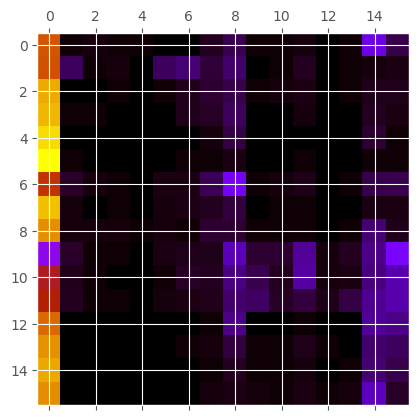

In [46]:
import matplotlib.pyplot as plt
plt.matshow(attention[layer][0][head], cmap='gnuplot')

## Extract contextual word embeddings



In [18]:
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)

def get_word_vector(inputs, outputs, idx, layer):
    """Get a word vector by averaging the embeddings of 
       all word occurrences of that word in the input"""

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == idx)
    print(inputs.word_ids())
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]
    print(token_ids_word)
    return word_tokens_output.mean(dim=0)

# The code below converts the tokens into a space delimited string.
# This will allow computing in which position of the BERT input sequence a given word is.
sentence_a = tokenizer.decode(inputs["input_ids"][0].tolist()).replace("[CLS] ", '').replace(" [SEP]", '')
word = "treatable"
idx = get_word_idx(sentence_a, word)
print("Input sequence:", sentence_a)
print("The word \"", word, "\" occurs in position", idx, "of the BERT input sequence.")

word_embedding = get_word_vector(inputs, outputs, idx, 4)


Input sequence: is throat cancer treatable nowadays? tell me about lung cancer.
The word " treatable " occurs in position 3 of the BERT input sequence.
[None, 0, 1, 2, 3, 3, 4, 5, None, 0, 1, 2, 3, 4, 5, None]
(array([ 4,  5, 12]),)


In [19]:
import torch
import re
from transformers import AutoTokenizer, AutoModel

def get_word_vector_from_ab(inputs, outputs, word, layer = '-1', ab = 'A'):
    """
    This method extracts a word embedding from the requested layer 
    for sentence_a or sentence_b. If the word is divided into tokens, 
    the word embedding will be the average of the corresponding token 
    embeddings.

    NOTE: If the same word occurs multiple times in the sentence, 
    this method returns the word embedding of the first occurrence.

    Keyword arguments:
        inputs -- input passed to the transformer
        outputs -- output of the transformer
        word -- target word
        layer -- layer from where the word embedding vector should 
        be extracted.
        ab -- should be 'A' or 'B' indication if the word embedding is to be extracted 
        from sentence_a or sentence_b, i.e., query or document.
    """
       
    sep_token = np.where(np.array(inputs["input_ids"][0].tolist()) == 102)[0][0]
    if ab == 'A':
        tokens_a = inputs["input_ids"][0][1:sep_token]
        sent = tokenizer.decode(tokens_a.tolist())
    else:
        tokens_b = inputs["input_ids"][0][sep_token+1:-1]
        sent = tokenizer.decode(tokens_b.tolist())

    word_ids = get_word_idx(sent, word)

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == word_ids)[0]
    sep_word = np.where(np.array(inputs.word_ids()) == None)[0][1]

    if ab == 'A':
        token_pos = token_ids_word < sep_word
    else:
        token_pos = token_ids_word > sep_word
        
    token_ids_word = token_ids_word[token_pos]
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]

    # Change this to True for inspection
    details = True
    if details:
        input_id_list = input_ids[0].tolist() # Batch index 0
        tokens = tokenizer.convert_ids_to_tokens(input_id_list)
        str1 = " "

        print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
        print("INPUT SEQUENCE TOKENS: ", str1.join(tokens))
        print("TARGET WORD:", word)
        print("TARGET SENTENCE:", ab)
        print("TARGET SENTENCE WORDS [", sent, "]")
        print("The word [", word, "] occurs in position", idx, "of the BERT input sentence", ab)
        print("The word [", word, "] corresponds to the token(s)", token_ids_word, "of the BERT input sequence", ab)

    return word_tokens_output.mean(dim=0)


word_embedding = get_word_vector_from_ab(inputs, outputs, "treatable", 4, 'A')


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
INPUT SEQUENCE TOKENS:  [CLS] is throat cancer treat ##able nowadays ? [SEP] tell me about lung cancer . [SEP]
TARGET WORD: treatable
TARGET SENTENCE: A
TARGET SENTENCE WORDS [ is throat cancer treatable nowadays? ]
The word [ treatable ] occurs in position 3 of the BERT input sentence A
The word [ treatable ] corresponds to the token(s) [4 5] of the BERT input sequence A


In [20]:
word_embedding.size()

torch.Size([768])

# Visualization

## Visualization of the positional embeddings

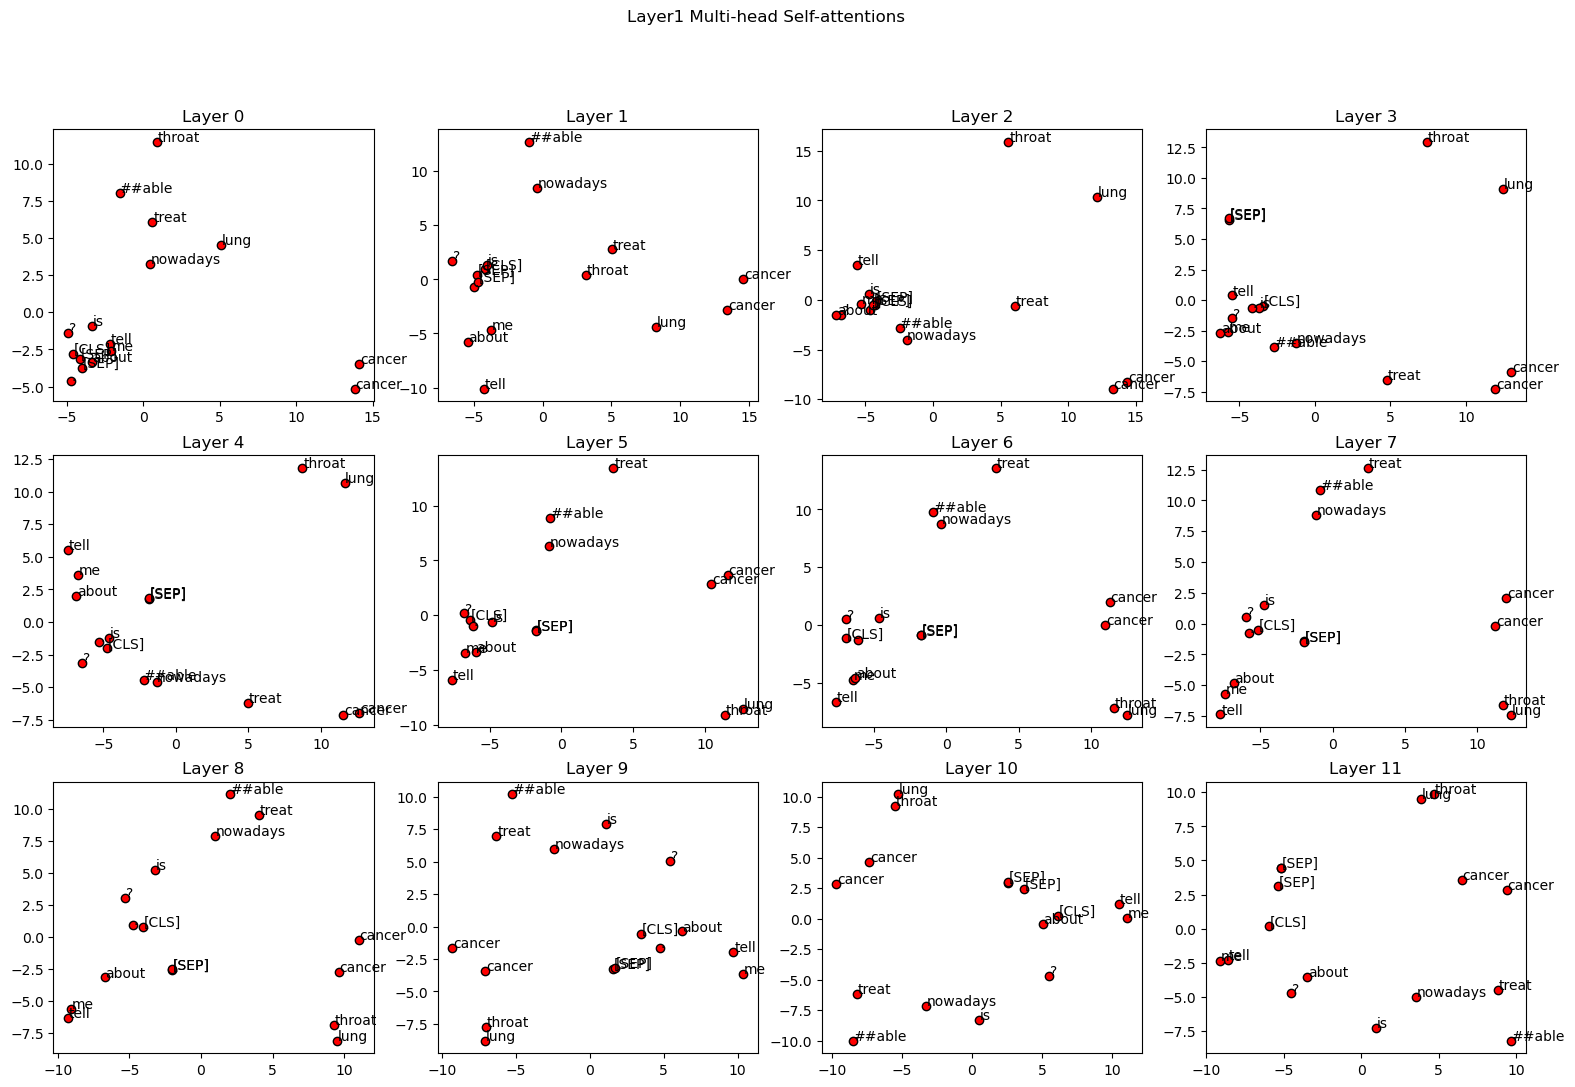

In [38]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        model = hidden_states[j][0].detach().numpy()
        
        if model.shape[1] == 2:
            twodim = model
        else:
            twodim = PCA().fit_transform(model)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(tokens, twodim):
            ax.text(x+0.05, y+0.05, word)
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(j))
            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
plt.show()

## Token specific visualzation of self-attention

More details are available here: https://github.com/jessevig/bertviz

In [26]:
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

## Visualization of all the heads in one layer

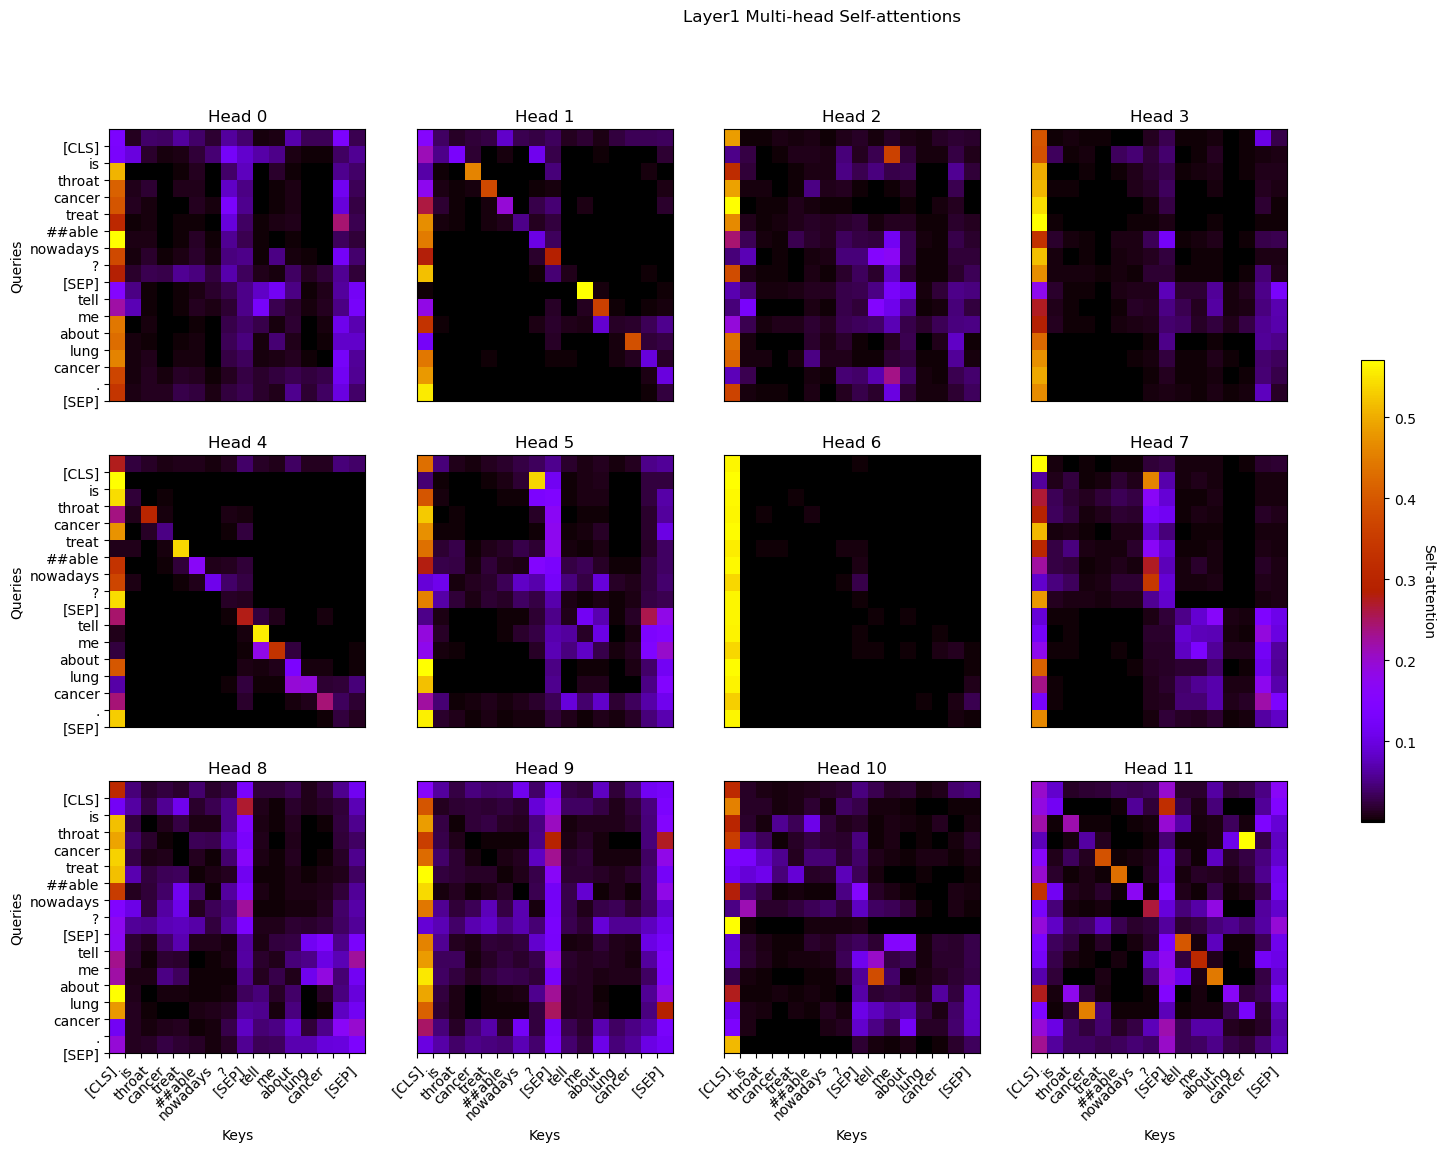

In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention = attention[layer][0][j].numpy()
        sattention = np.flip(sattention, 0)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        ax.set_yticks(np.arange(len(tokens)))
        if c == 0:
            ax.set_yticklabels(reversed(tokens))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokens)))
        if r == rows-1:
            ax.set_xticklabels(tokens)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()

## Visualzation of Self-Attention in all layers and heads

In [39]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>